# Fine Tuning Transformer for Summary Generation


### Introduction

In this tutorial we will be fine tuning a transformer model for **Summarization Task**. 
In this task a summary of a given article/document is generated when passed through a network. There are 2 types of summary generation mechanisms:

1. ***Extractive Summary:*** the network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.
2. ***Abstractive Summary***: The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article. 

In this tutorial we will be generating ***Abstractive Summary***. 

#### Flow of the notebook

* As with all the tutorials previously, this notebook also follows a easy to follow steps. Making the process of fine tuning and training a Transformers model a straight forward task.
* However, unlike the other notebooks, in the tutorial, most of the sections have been created into functions, and they are called from the `main()` in the end of the notebook. 
* This is done to leverage the [Weights and Biases Service](https://www.wandb.com/) WandB in short.
* It is a experiment tracking, parameter optimization and artifact management service. That can be very easily integrated to any of the Deep learning or Machine learning frameworks. 

The notebook will be divided into separate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Preparing Environment and Importing Libraries](#section01)
2. [Preparing the Dataset for data processing: Class](#section02)
3. [Fine Tuning the Model: Function](#section03)
4. [Validating the Model Performance: Function](#section04)
5. [Main Function](#section05)
    * [Initializing WandB](#section501)
    * [Importing and Pre-Processing the domain data](#section502)
    * [Creation of Dataset and Dataloader](#section503)
    * [Neural Network and Optimizer](#section504)
    * [Training Model and Logging to WandB](#section505)
    * [Validation and generation of Summary](#section506)
6. [Examples of the Summary Generated from the model](#section06)


#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

- **Data**:
	- We are using the News Summary dataset available at [Kaggle](https://www.kaggle.com/sunnysai12345/news-summary)
	- This dataset is the collection created from Newspapers published in India, extracting, details that are listed below.  We are referring only to the first csv file from the data dump: `news_summary.csv`
	- There are`4514` rows of data.  Where each row has the following data-point:
		- **author** : Author of the article
		- **date** : Date the article was published
		- **headline**: Headline for the published article
		- **read_more** : URL for the article to follow online
		- **text**: This is the summary of the article
		- **ctext**: This is the complete article


- **Language Model Used**: 
    - This notebook uses one of the most recent and novel transformers model ***T5***. [Research Paper](https://arxiv.org/abs/1910.10683)    
    - ***T5*** in many ways is one of its kind transformers architecture that not only gives state of the art results in many NLP tasks, but also has a very radical approach to NLP tasks.
    - **Text-2-Text** - According to the graphic taken from the T5 paper. All NLP tasks are converted to a **text-to-text** problem. Tasks such as translation, classification, summarization and question answering, all of them are treated as a text-to-text conversion problem, rather than seen as separate unique problem statements.
    - **Unified approach for NLP Deep Learning** - Since the task is reflected purely in the text input and output, you can use the same model, objective, training procedure, and decoding process to ANY task. Above framework can be used for any task - show Q&A, summarization, etc. 
   - We will be taking inputs from the T5 paper to prepare our dataset prior to fine tuning and training.    
   - [Documentation for python](https://huggingface.co/transformers/model_doc/t5.html)

![**Each NLP problem as a “text-to-text” problem** - input: text, output: text](https://miro.medium.com/max/4006/1*D0J1gNQf8vrrUpKeyD8wPA.png) 
	 


- Hardware Requirements: 
	- Python 3.6 and above
	- Pytorch, Transformers and
	- All the stock Python ML Library
	- GPU enabled setup 
   

- **Script Objective**:
	- The objective of this script is to fine tune ***T5 *** to be able to generate summary, that a close to or better than the actual summary  while ensuring the important information from the article is not lost.

---
NOTE: 
We are using the Weights and Biases Tool-set in  this tutorial. The different components will be explained as we go through the article.

<a id='section01'></a>
### Preparing Environment and Importing Libraries

At this step we will be installing the necessary libraries followed by importing the libraries and modules needed to run our script. 
We will be installing:
* transformers
* wandb

Libraries imported are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* T5 Model and Tokenizer
* wandb

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU. First we will check the GPU avaiable to us, using the nvidia command followed by defining our device.

Finally, we will be logging into the [wandb](https://www.wandb.com/) serice using the login command

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/code/CS224N

Mounted at /content/drive
/content/drive/MyDrive/code/CS224N


In [3]:
! ls data

mydata.csv  SCBAll.csv	       SCBAll_trained2.csv  SCBAll_trained.csv
mydata.pkl  SCBAll_pruned.csv  SCBAll_trained3.csv  SCB_all_v2.csv


In [4]:
!pip install sentencepiece
!pip install bert-score

     |████████████████████████████████| 1.2 MB 8.1 MB/s 
     |████████████████████████████████| 60 kB 5.0 MB/s 
     |████████████████████████████████| 3.8 MB 15.7 MB/s 
     |████████████████████████████████| 895 kB 57.4 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 6.5 MB 55.9 MB/s 
     |████████████████████████████████| 596 kB 77.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install transformers -q
!pip install wandb -q

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 144 kB 78.3 MB/s 
     |████████████████████████████████| 181 kB 69.9 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [6]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Importing the T5 modules from huggingface/transformers
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import T5ForConditionalGeneration
# from transformers import AutoTokenizer as T5Tokenizer
# from transformers import AutoModelWithLMHead as T5ForConditionalGeneration
from transformers import AutoModelWithLMHead, AutoTokenizer
# AutoModelWithLMHead
from bert_score import score

# tokenizer = AutoTokenizer.from_pretrained("t5-base")

# model = AutoModelWithLMHead.from_pretrained("t5-base")

# WandB – Import the wandb library
import wandb

In [7]:
# Checking out the GPU we have access to. This is output is from the google colab version. 
!nvidia-smi

Mon Mar 14 02:40:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [9]:
# Login to wandb to log the model run and all the parameters
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<a id='section02'></a>
### Preparing the Dataset for data processing: Class

We will start with creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. This dataset will be used the the Dataloader method that will feed  the data in batches to the neural network for suitable training and processing. 
The Dataloader and Dataset will be used inside the `main()`.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the **T5** model for training. 
- We are using the **T5** tokenizer to tokenize the data in the `text` and `ctext` column of the dataframe. 
- The tokenizer uses the ` batch_encode_plus` method to perform tokenization and generate the necessary outputs, namely: `source_id`, `source_mask` from the actual text and `target_id` and `target_mask` from the summary text.
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/t5.html#t5tokenizer)
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader: Called inside the `main()`
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of data loaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [23]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset): ### seq2seq from ctext to text

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

<a id='section03'></a>
### Fine Tuning the Model: Function

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

This function is called in the `main()`

Following events happen in this function to fine tune the neural network:
- The epoch, tokenizer, model, device details, testing_ dataloader and optimizer are passed to the `train ()` when its called from the `main()`
- The dataloader passes data to the model based on the batch size.
- `language_model_labels` are calculated from the `target_ids` also, `source_id` and `attention_mask` are extracted.
- The model outputs first element gives the loss for the forward pass. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 10 steps the loss value is logged in the wandb service. This log is then used to generate graphs for analysis. Such as [these](https://app.wandb.ai/abhimishra-91/transformers_tutorials_summarization?workspace=user-abhimishra-91)
- After every 500 steps the loss value is printed in the console.

In [24]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network 
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        # lm_labels = y[:, 1:].clone().detach()
        # lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        lm_labels = y[:, :].clone().detach()
        lm_labels[lm_labels == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        # outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        # outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        outputs = model(input_ids = ids, attention_mask = mask, labels=lm_labels)
        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

<a id='section04'></a>
### Validating the Model Performance: Function

During the validation stage we pass the unseen data(Testing Dataset), trained model, tokenizer and device details to the function to perform the validation run. This step generates new summary for dataset that it has not seen during the training session. 

This function is called in the `main()`

This unseen data is the 20% of `news_summary.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. We use the generate method for generating new text for the summary. 

It depends on the `Beam-Search coding` method developed for sequence generation for models with LM head. 

The generated text and originally summary are decoded from tokens to text and returned to the `main()`

In [25]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

<a id='section05'></a>
### Main Function

The `main()` as the name suggests is the central location to execute all the functions/flows created above in the notebook. The following steps are executed in the `main()`:


<a id='section501'></a>
#### Initializing WandB 

* The `main()` begins with initializing WandB run under a specific project. This command initiates a new run for each execution of this command. 

* Before we proceed any further i will give a brief overview of the **[WandB Service](https://www.wandb.com/)**

* This service has been created to track ML experiments, Optimize the experiments and save artifacts. It is designed to seamlessly integrate with all the Machine Learning and Deep Learning Frameworks. Each script can be organized into *Project* and each execution of the script will be registered as a *run* in the respective project.

* The service can be configured to log several default metrics, such a network weights, hardware usage, gradients and weights of the network. 

* It can also be used to log user defined metrics, such a loss in the `train()`.

* This particular tutorial is logged in the project: **[transformers_tutorials_summarization](https://app.wandb.ai/abhimishra-91/transformers_tutorials_summarization?workspace=user-abhimishra-91)**

**One of the charts from the project**
![](meta/wandb.png)

* Visit the project page to see the details of different runs and what information is logged by the service. 

* Following the initialization of the WandB service we define configuration parameters that will be used across the tutorial such as `batch_size`, `epoch`, `learning_rate` etc.

* These parameters are also passed to the WandB config. The config construct with all the parameters can be optimized using the Sweep service from WandB. Currently, that is outof scope of this tutorial. 

* Next we defining seed values so that the experiment and results can be reproduced.


<a id='section502'></a>
#### Importing and Pre-Processing the domain data

We will be working with the data and preparing it for fine tuning purposes. 
*Assuming that the `news_summary.csv` is already downloaded in your `data` folder*

* The file is imported as a dataframe and give it the headers as per the documentation.
* Cleaning the file to remove the unwanted columns.
* A new string is added to the main article column `summarize: ` prior to the actual article. This is done because **T5** had similar formatting for the summarization dataset. 
* The final Dataframe will be something like this:

|text|ctext|
|--|--|
|summary-1|summarize: article 1|
|summary-2|summarize: article 2|
|summary-3|summarize: article 3|

* Top 5 rows of the dataframe are printed on the console.

<a id='section503'></a>
#### Creation of Dataset and Dataloader

* The updated dataframe is divided into 80-20 ratio for test and validation. 
* Both the data-frames are passed to the `CustomerDataset` class for tokenization of the new articles and their summaries.
* The tokenization is done using the length parameters passed to the class.
* Train and Validation parameters are defined and passed to the `pytorch Dataloader contstruct` to create `train` and `validation` data loaders.
* These dataloaders will be passed to `train()` and `validate()` respectively for training and validation action.
* The shape of datasets is printed in the console.


<a id='section504'></a>
#### Neural Network and Optimizer

* In this stage we define the model and optimizer that will be used for training and to update the weights of the network. 
* We are using the `t5-base` transformer model for our project. You can read about the `T5 model` and its features above. 
* We use the `T5ForConditionalGeneration.from_pretrained("t5-base")` commad to define our model. The `T5ForConditionalGeneration` adds a Language Model head to our `T5 model`. The Language Model head allows us to generate text based on the training of `T5 model`.
* We are using the `Adam` optimizer for our project. This has been a standard for all our tutorials and is something that can be changed updated to see how different optimizer perform with different learning rates. 
* There is also a scope for doing more with Optimizer such a decay, momentum to dynamically update the Learning rate and other parameters. All those concepts have been kept out of scope for these tutorials. 


<a id='section505'></a>
#### Training Model and Logging to WandB

* Now we log all the metrics in WandB project that we have initialized above.
* Followed by that we call the `train()` with all the necessary parameters.
* Loss at every 500th step is printed on the console.
* Loss at every 10th step is logged as Loss in the WandB service.


<a id='section506'></a>
#### Validation and generation of Summary

* After the training is completed, the validation step is initiated.
* As defined in the validation function, the model weights are not updated. We use the fine tuned model to generate new summaries based on the article text.
* An output is printed on the console giving a count of how many steps are complete after every 100th step. 
* The original summary and generated summary are converted into a list and returned to the main function. 
* Both the lists are used to create the final dataframe with 2 columns **Generated Summary** and **Actual Summary**
* The dataframe is saved as a csv file in the local drive.
* A qualitative analysis can be done with the Dataframe. 

In [ ]:
# def main():
#     # WandB – Initialize a new run
#     wandb.init(project="transformers_tutorials_summarization")

#     # WandB – Config is a variable that holds and saves hyperparameters and inputs
#     # Defining some key variables that will be used later on in the training  
#     config = wandb.config          # Initialize config
#     config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
#     config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
#     config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
#     config.VAL_EPOCHS = 1 
#     config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
#     config.SEED = 42               # random seed (default: 42)
#     config.MAX_LEN = 512
#     config.SUMMARY_LEN = 150 

#     # Set random seeds and deterministic pytorch for reproducibility
#     torch.manual_seed(config.SEED) # pytorch random seed
#     np.random.seed(config.SEED) # numpy random seed
#     torch.backends.cudnn.deterministic = True

#     # tokenzier for encoding the text
#     tokenizer = T5Tokenizer.from_pretrained("t5-base")
    

#     # Importing and Pre-Processing the domain data
#     # Selecting the needed columns only. 
#     # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task. 
#     df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
#     df = df[['text','ctext']]
#     df.ctext = 'summarize: ' + df.ctext
#     print(df.head())

    
#     # Creation of Dataset and Dataloader
#     # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
#     train_size = 0.8
#     train_dataset=df.sample(frac=train_size,random_state = config.SEED)
#     val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
#     train_dataset = train_dataset.reset_index(drop=True)

#     print("FULL Dataset: {}".format(df.shape))
#     print("TRAIN Dataset: {}".format(train_dataset.shape))
#     print("TEST Dataset: {}".format(val_dataset.shape))


#     # Creating the Training and Validation dataset for further creation of Dataloader
#     training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
#     val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

#     # Defining the parameters for creation of dataloaders
#     train_params = {
#         'batch_size': config.TRAIN_BATCH_SIZE,
#         'shuffle': True,
#         'num_workers': 0
#         }

#     val_params = {
#         'batch_size': config.VALID_BATCH_SIZE,
#         'shuffle': False,
#         'num_workers': 0
#         }

#     # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
#     training_loader = DataLoader(training_set, **train_params)
#     val_loader = DataLoader(val_set, **val_params)


    
#     # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
#     # Further this model is sent to device (GPU/TPU) for using the hardware.
#     model = T5ForConditionalGeneration.from_pretrained("t5-base")
#     model = model.to(device)

#     # Defining the optimizer that will be used to tune the weights of the network in the training session. 
#     optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

#     # Log metrics with wandb
#     wandb.watch(model, log="all")
#     # Training loop
#     print('Initiating Fine-Tuning for the model on our dataset')

#     for epoch in range(config.TRAIN_EPOCHS):
#         train(epoch, tokenizer, model, device, training_loader, optimizer)


#     # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
#     # Saving the dataframe as predictions.csv
#     print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
#     for epoch in range(config.VAL_EPOCHS):
#         predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
#         final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
#         final_df.to_csv('./models/predictions.csv')
#         print('Output Files generated for review')

# if __name__ == '__main__':
#     main()

In [12]:
# tmp = pd.read_csv('./predictions_10epochs.csv')
# tmp.to_csv('./predictions_10epochs_0.csv')

In [13]:
# from bert_score import score

In [30]:
df_val = pd.read_csv('df_val.csv')
df_test = pd.read_csv('df_test.csv')

In [15]:
df_val.columns


Index(['Unnamed: 0', 'Actual Text', 'Generated Text', 'Generated Text 1',
       'Generated Text 2', 'Generated Text 3', 'Generated Text 4',
       'Generated Text 5', 'Generated Text 6', 'Generated Text 7',
       'Generated Text 8', 'Generated Text 9', 'Generated Text 10',
       'Generated Text 11', 'Generated Text 12', 'Generated Text 13',
       'Generated Text 14', 'Generated Text 15', 'Generated Text 16',
       'Generated Text 17', 'Generated Text 18', 'Generated Text 19',
       'Generated Text 20'],
      dtype='object')

In [28]:
pd.concat([val_dataset[['title']],df_val[['Actual Text','Generated Text','Generated Text 20']]], axis=1)

,title,Actual Text,Generated Text,Generated Text 20
0,‘Toy Story 4’ Boycotted by Christian Group Ove...,Scene in comments.,Toy Story 4 was a hit with kids.,One Million Moms.
1,Mary Tyle Moore's Cause of Death Revealed,Cardiopulmonary arrest.,She died of cardiopulmonary arrest,Cardiopulmonary arrest.
2,Adding This 1 Ridiculous Word Will Improve You...,Cheers.,No answer available in context,Cheers.
3,Gamer figures out how much the full Battlefiel...,"$120. $70 for the game, $50 for all the DLC",No answer available in context,$120.
4,Cam Newton Busts Out Gunslinger Look With Epic...,Picture in the comments.,No answer available in context,Patriots quarterback Cam Newton wore a gunslin...
...,...,...,...,...
121,Will wearing water jugs on your head combat co...,The CDC doesn't recommend it.,No answer available in context,Yes.
122,Here's Why Flight Attendants Ask You to Raise ...,So the crew can assess the surroundings in an ...,No answer available in context,To ensure safety.
123,You won't be able to buy some corded blinds st...,Industry standards are eliminating/reducing si...,No answer available in context,To prevent child strangulation.
124,Australia Will Suddenly Move 1.8 Meters North ...,Australians aren't actually going anywhere...t...,"No, the country will jut northwards by 1.8 met...",The Australian Plate is moving about 7 centime...


In [31]:
pd.concat([test_dataset[['title']],df_test[['Actual Text','Generated Text','Generated Text 20']]], axis=1)

,title,Actual Text,Generated Text,Generated Text 20
0,"Fans Leaving The Show, Because Of This… AMC Pa...",The Walking Dead has become more about gore th...,They are blaming the showrunner for their mani...,They feel the show is manipulating its audienc...
1,It took more than Ian McShane and a prayer to ...,"Basically, HBO handed back the rights because ...",No answer available in context,"""This is the first time I'm saying this in an ..."
2,This Couple Had a Pizza Instead of Cake At The...,Pizza. It's literally right in the picture.,They had a pizza instead of cake at their wedd...,They served it in a pizza box.
3,Oprah Winfrey's 'greatest extravagance' is fro...,English Muffins from The Model Bakery.,The muffins are made by two women in Napa Valley.,English muffins.
4,Rogue One Writer Can't Believe What Disney Let...,He killed all the main characters.,They are a part of the Star Wars universe.,"""They can't kill everybody."""
...,...,...,...,...
120,This Is The Rarest Hair And Eye Color Combination,Red hair and blue eyes (0.017% of people.),"No, it’s not blue.",Red hair and blue eyes.
121,This is why Emma Watson avoids taking selfies ...,She doesn't like her location being revealed o...,No answer available in context,Because they're tracked.
122,Stop Picky Eating with this One Simple Phrase,"""You don't have to eat it.""",They have to try it.,They won't.
123,Ross Lynch Will Play An Iconic Character On Ne...,Ross Lynch.,No answer available in context,Ross Lynch


In [37]:
# P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp['Generated Text'].tolist()], lang='en')
# f1scores = F1.tolist()
# epochs = [0]*len(F1)
# for epoch in range(1,11):
#   P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp[f'Generated Text {epoch}'].tolist()], lang='en')
#   f1scores += F1.tolist()
#   epochs += [epoch]*len(F1)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaM

In [32]:
# f1scores

In [68]:
# plt.plot(epochs, f1scores, yerr = epochs)

# sns.lineplot(x=epochs, y=f1scores, ci='sd')
# plt.xlabel('Epochs')
# plt.ylabel('F1 score')
# plt.savefig('validation_score.png')
# sns.lineplot(x=[1,2], y=[2,4],ci=[1,3])

In [18]:
# df = pd.read_csv('./data/SCBAll_pruned.csv')
df = pd.read_csv('./data/SCB_all_v2.csv')
# df = df[['text','ctext']]
# df.ctext = 'summarize: ' + df.ctext
# print(df.head())


In [19]:
## for pruning; no need to run if you load pruned data
df = df[['article', 'title', 'summary']]
df = df.dropna()
for i in range(len(df)):
  if '#' in df.loc[df.index[i],'summary']:
    print(i)
    df.loc[df.index[i],'summary'] = ' '.join([i  if '#' not in i else ''  for i in df.loc[df.index[i],'summary'].split(' ')])

7
15
45
46
47
48
53
69
71
74
81
159
163
164
165
172
256
364
419
420
421
422
423
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
446
602
616
642
1251


In [20]:
# df.to_csv('SCB_pruned2.csv')

In [21]:
df['ctext'] = "context: "+df.article +" <question for context: "+ df.title +" </s>"
df['text'] = df.summary

In [18]:
# df_test = df.iloc[-len(df)//10]
# df = df.iloc[:-len(df)//10]

In [19]:
len(df)
# df.head()

1257

In [26]:

# WandB – Initialize a new run
wandb.init(project="transformers_tutorials_summarization")

# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training  
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 20        # number of epochs to train (default: 10)
config.VAL_EPOCHS = 1 
config.LEARNING_RATE = 1e-5    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)
config.MAX_LEN = 512
config.SUMMARY_LEN = 150 

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(config.SEED) # pytorch random seed
np.random.seed(config.SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

# tokenzier for encoding the text
# tokenizer = T5Tokenizer.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("tuner007/t5_abs_qa")



# Importing and Pre-Processing the domain data
# Selecting the needed columns only. 
# Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task. 
# df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
# df = df[['text','ctext']]
# df.ctext = 'summarize: ' + df.ctext
# print(df.head())


# Creation of Dataset and Dataloader
# Defining the train size. So 90% of the rest of data (10% already taken for test, so 0.81) will be used for training and the rest will be used for validation. 
train_size = 0.8
val_size = 0.1 ### the rest goes to test
train_dataset=df.sample(frac=train_size,random_state = config.SEED)
# val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
val_test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
val_dataset=val_test_dataset.sample(frac=val_size / (1-train_size),random_state = config.SEED)
test_dataset=val_test_dataset.drop(val_dataset.index).reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(val_dataset.shape))


# Creating the Training and Validation dataset for further creation of Dataloader
training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
test_set = CustomDataset(test_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': config.TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
    }

val_params = {
    'batch_size': config.VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
    } ### also used for test set

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **val_params)


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


FULL Dataset: (1257, 5)
TRAIN Dataset: (1006, 5)
TEST Dataset: (126, 5)


In [25]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1006, 126, 125)

In [11]:
 # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
# Further this model is sent to device (GPU/TPU) for using the hardware.
# model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = AutoModelWithLMHead.from_pretrained("tuner007/t5_abs_qa")
model = model.to(device)
# model.load_state_dict(torch.load('model_20epochs_state_dict'))

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

# Log metrics with wandb
wandb.watch(model, log="all")
# Training loop
print('Initiating Fine-Tuning for the model on our dataset')

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:882: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

NameError: ignored

In [27]:
# df
predictions, actuals = validate(0, tokenizer, model, device, val_loader)
df_val = pd.DataFrame({'Actual Text':actuals, 'Generated Text':predictions})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Completed 0


In [28]:
# df
predictions, actuals = validate(0, tokenizer, model, device, test_loader)
df_test = pd.DataFrame({'Actual Text':actuals, 'Generated Text':predictions})

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Completed 0


In [29]:
for epoch in range(config.TRAIN_EPOCHS):
# for epoch in range(config.TRAIN_EPOCHS, config.TRAIN_EPOCHS*2):
    train(epoch, tokenizer, model, device, training_loader, optimizer)
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    df_val[f'Generated Text {epoch+1}'] = predictions
    predictions, actuals = validate(epoch, tokenizer, model, device, test_loader)
    df_test[f'Generated Text {epoch+1}'] = predictions
    # final_df[f'Actual Text {epoch+1}'] = actuals

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  3.235375165939331
Epoch: 0, Loss:  0.9674309492111206
Completed 0
Completed 0
Epoch: 1, Loss:  1.8763514757156372
Epoch: 1, Loss:  1.52723228931427
Completed 0
Completed 0
Epoch: 2, Loss:  1.0854079723358154
Epoch: 2, Loss:  4.263283729553223
Completed 0
Completed 0
Epoch: 3, Loss:  0.5704552531242371
Epoch: 3, Loss:  3.7501766681671143
Completed 0
Completed 0
Epoch: 4, Loss:  2.8043479919433594
Epoch: 4, Loss:  2.338731527328491
Completed 0
Completed 0
Epoch: 5, Loss:  2.7318851947784424
Epoch: 5, Loss:  0.5311393141746521
Completed 0
Completed 0
Epoch: 6, Loss:  1.9248708486557007
Epoch: 6, Loss:  2.9369451999664307
Completed 0
Completed 0
Epoch: 7, Loss:  1.7517833709716797
Epoch: 7, Loss:  0.16751804947853088
Completed 0
Completed 0
Epoch: 8, Loss:  2.0895678997039795
Epoch: 8, Loss:  1.1681727170944214
Completed 0
Completed 0
Epoch: 9, Loss:  1.821096420288086
Epoch: 9, Loss:  1.6945159435272217
Completed 0
Completed 0
Epoch: 10, Loss:  2.5235583782196045
Epoch: 1

In [30]:
df_val

,Actual Text,Generated Text,Generated Text 1,Generated Text 2,Generated Text 3,Generated Text 4,Generated Text 5,Generated Text 6,Generated Text 7,Generated Text 8,...,Generated Text 11,Generated Text 12,Generated Text 13,Generated Text 14,Generated Text 15,Generated Text 16,Generated Text 17,Generated Text 18,Generated Text 19,Generated Text 20
0,Scene in comments.,Toy Story 4 was a hit with kids.,Toy Story 4 was a hit.,Toy Story 4 was released on June 21st.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,...,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.,One Million Moms.
1,Cardiopulmonary arrest.,She died of cardiopulmonary arrest,She died of cardiopulmonary arrest.,She died of cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,...,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.,Cardiopulmonary arrest.
2,Cheers.,No answer available in context,It did.,"""Cheers"" as your sign-off.","""Cheers""","""Cheers"" as your sign-off.","""Cheers.""","""Cheers.""","""Cheers.""","""Cheers.""",...,"""Cheers.""","""Cheers.""","""Cheers.""",Cheers.,Cheers.,Cheers.,Cheers.,Cheers.,Cheers.,Cheers.
3,"$120. $70 for the game, $50 for all the DLC",No answer available in context,$120.,$120.,$120.,$120.,$120.,$120.,$120.,$120.,...,$120.,$120.,$120.,$120.,$120.,$120.,$120.,$120.,$120.,$120.
4,Picture in the comments.,No answer available in context,Cam Newton wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,...,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,He wore a gunslinger outfit.,Patriots quarterback Cam Newton wore a gunslin...,Patriots quarterback Cam Newton wore a gunslin...,He wore a gunslinger outfit.,Patriots quarterback Cam Newton wore a gunslin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,The CDC doesn't recommend it.,No answer available in context,No.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,...,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.,Yes.
122,So the crew can assess the surroundings in an ...,No answer available in context,They want to protect passengers and crew from ...,They want to protect passengers and crew.,They want to ensure safety.,They want to ensure safety.,They want to ensure safety.,It's for safety.,To ensure safety.,To ensure safety.,...,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.,To ensure safety.
123,Industry standards are eliminating/reducing si...,No answer available in context,Corded blinds are dangerous to children.,Corded blinds.,Corded blinds.,Corded blinds.,Corded blinds.,Corded blinds.,Corded blinds.,Corded blinds.,...,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.,To prevent child strangulation.
124,Australians aren't actually going anywhere...t...,"No, the country will jut northwards by 1.8 met...",The Australian Plate is moving about 7 centime...,The Australian Plate is moving about 7 centime...,The Australian Plate is moving about 7 centime...,The Australian Plate is moving about 7 c

In [35]:
df_val.to_csv('./df_val.csv')
df_test.to_csv('./df_test.csv')

In [32]:
# wandb.finish()

In [36]:
len(df_val)

126

In [53]:
torch.save(model.state_dict(),'model_20epochs_state_dict')

In [12]:
# torch.load_state_dict('model_20epochs_state_dict')
model.load_state_dict(torch.load('model_20epochs_state_dict'))

<All keys matched successfully>

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaM

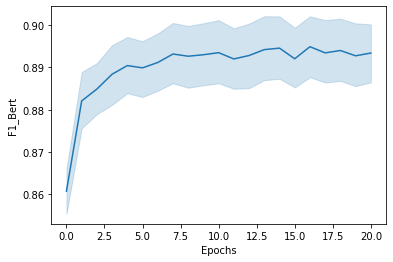

In [49]:
tmp = df_val
P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp['Generated Text'].tolist()], lang='en')
f1scores_val = F1.tolist()
epochs_val = [0]*len(F1)
avgs_val = [np.average(f1scores)]
for epoch in range(1,21):
  P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp[f'Generated Text {epoch}'].tolist()], lang='en')
  f1scores_val += F1.tolist()
  epochs_val += [epoch]*len(F1)
  avgs_val.append(np.average(F1.tolist()))
# sns.lineplot(x=epochs, y=f1scores, ci='sd')
sns.lineplot(x=epochs_val, y=f1scores_val, ci=95)
plt.xlabel('Epochs')
plt.ylabel('F1_Bert')
plt.savefig('validation_score.png')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaM

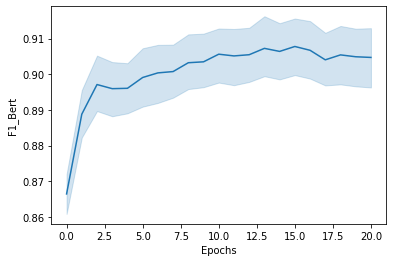

In [50]:
tmp = df_test
P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp['Generated Text'].tolist()], lang='en')
f1scores_test = F1.tolist()
epochs_test = [0]*len(F1)
avgs_test = [np.average(f1scores)]
for epoch in range(1,21):
  P, R, F1 = score([str(i) for i in tmp['Actual Text'].tolist()], [str(i) for i in tmp[f'Generated Text {epoch}'].tolist()], lang='en')
  f1scores_test += F1.tolist()
  epochs_test += [epoch]*len(F1)
  avgs_test.append(np.average(F1.tolist()))
# sns.lineplot(x=epochs, y=f1scores, ci='sd')
sns.lineplot(x=epochs_test, y=f1scores_test, ci=95)
plt.xlabel('Epochs')
plt.ylabel('F1_Bert')
plt.savefig('test_score.png')

In [48]:
# sns.lineplot(x=epochs+epochs[-1:]*1000, y=f1scores+f1scores[-21:-20]*1000)

In [51]:
avgs_test


[0.9007139695712498,
 0.8888025188446045,
 0.8971212644577027,
 0.8959635577201843,
 0.8960647253990174,
 0.8990968532562256,
 0.9003901939392089,
 0.9007612872123718,
 0.9032401289939881,
 0.9034955520629883,
 0.9056349878311157,
 0.9051502294540406,
 0.9054881272315979,
 0.9072710828781128,
 0.9064169182777405,
 0.9077996139526368,
 0.9067304992675781,
 0.9040553059577942,
 0.9054397668838501,
 0.904916265964508,
 0.9047256751060486]

In [52]:
avgs_val


[0.9007139695712498,
 0.8820711525659712,
 0.8848751201516106,
 0.8883750410307021,
 0.8904118675088125,
 0.8898781973218161,
 0.8911398294426146,
 0.8931414480247195,
 0.8926203061663915,
 0.8929717781997862,
 0.8934601464914897,
 0.8919769733671158,
 0.8927901401406243,
 0.8941775517804282,
 0.8945314642928895,
 0.8920150872260805,
 0.894870260405162,
 0.8934100544641889,
 0.893971167859577,
 0.892719532762255,
 0.893372861165849]

In [27]:
# Validation loop and saving the resulting file with predictions and acutals in a dataframe.
# Saving the dataframe as predictions.csv
# print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
# for epoch in range(config.VAL_EPOCHS):
#     predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
#     final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
#     final_df.to_csv('./predictions.csv')
#     print('Output Files generated for review')

Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Completed 0
Output Files generated for review


In [28]:
final_df

,Generated Text,Actual Text
0,The four-legged star behind Jon Snow's faithfu...,Ghost.
1,No.,He was traded to Nashville to be closer to his...
2,Pants.,They once agreed that if they ever won a Gramm...
3,"""This is the first time I'm saying this in an ...","Basically, HBO handed back the rights because ..."
4,Pizza.,Pizza. It's literally right in the picture.
...,...,...
141,No.,To satisfy the demand for seafood.
142,"Machu Picchu (Machu Picchu, Peru)",Machu Picchu.
143,Two-thirds plan to leave their current organiz...,They don't feel like their leadership skills a...
144,The Israeli army has killed at least 206 Pales...,"Home demolitions, denial of building permits a..."


In [ ]:
for i,data in enumerate(training_loader, 0):
  if i>0:
    break
  y = data['target_ids'].to(device, dtype = torch.long)
  print(y.shape)
  print(tokenizer.decode(y[0]))
  print(tokenizer.decode(y[1]))

  y_ids = y[:, :-1].contiguous()
  lm_labels = y[:, 1:].clone().detach()
  # lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

  print(tokenizer.decode(y_ids[0]))
  print(tokenizer.decode(y_ids[1]))
  print(tokenizer.decode(lm_labels[0]))
  print(tokenizer.decode(lm_labels[1]))

  ids = data['source_ids'].to(device, dtype = torch.long)
  mask = data['source_mask'].to(device, dtype = torch.long)

  outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)


torch.Size([2, 150])
The regional transport authority has allowed the bike taxis to operate in four Uttar Pradesh districts including Ghaziabad, Gautam Budh Nagar, Hapur and Bulandshahr. There are 17 conditions that have to be fulfilled in order to get a permit for registering a bike taxi, according to the officials. Startups like Rapido, Baxi, Ola and Uber provide bike taxis.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
A forest department report submitted to the High Court suggested that all the seven domesticated elephants of Delhi be shifted to a sanctuary outside the city. It observed that not only were the elephants kept in poor conditions, but it was also risky to house them in crowded localities. Most of the elephants 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model(input_ids = ids, attention_mask = mask, labels=y[:, :].clone().detach())[0]

tensor(7.4522, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)[0]

tensor(7.7485, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tokenizer.decode(model_original.generate(input_ids = ids, attention_mask = mask)[0])

NameError: ignored

In [ ]:
tokenizer.decode(model2.generate(input_ids = ids, attention_mask = mask)[0])

NameError: ignored

In [ ]:
tokenizer.decode(data['source_ids'][0])

'summarize: Karachi, Apr 30 (PTI) Bollywood superstar Salman Khans much awaited film "Tubelight" might not hit the screens on Eid in Pakistan as some local filmmakers have started a movement to stall the release of the film. The filmmakers along with the Film Distributors Association and the Film Producers Association want to ensure better business for Pakistani films during the Eid holidays. The distributors, producers and filmmakers say they want to protect the interest of Pakistani movies as two big films, "Yalghaar" and "Shor Sharaba", along with others in the pipeline, are slated for an Eid release. "If Tubelight also releases on Eid, it will certainly hit the business of these Pakistani films and that will not help our industry," actor Mustafa Qureshi said. Those trying to stall the release of the Salman KhaN- starrer are citing a law passed by the Federal Ministry of Information in 2010 which forbids the release of any Indian film on a Muslim holiday. "If required we can even go

In [ ]:
tokenizer.decode(model.generate(input_ids = ids, attention_mask = mask)[0])

'<pad> UP Regional Transport Authority has given a green signal to bike taxis in four UP'

In [ ]:
tokenizer.decode(y_ids[0])

'The regional transport authority has allowed the bike taxis to operate in four Uttar Pradesh districts including Ghaziabad, Gautam Budh Nagar, Hapur and Bulandshahr. There are 17 conditions that have to be fulfilled in order to get a permit for registering a bike taxi, according to the officials. Startups like Rapido, Baxi, Ola and Uber provide bike taxis.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [ ]:
outputs[1].shape

torch.Size([2, 149, 32128])

In [ ]:
lm_labels.shape

torch.Size([2, 149])

In [ ]:
final_df

,Generated Text,Actual Text
0,hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...
1,'State Bank of Tomato' opened in Uttar Pradesh...,The Congress party has opened a bank called 'S...
2,a 24-year-old Indian athlete has been indicted...,"Tanveer Hussain, a 24-year-old Indian athlete ..."
3,the remains of a German hiker who disappeared ...,"The remains of a German hiker, who disappeared..."
4,"GP Manish Shah, who practised in east London, ...","A UK-based doctor, Manish Shah, has been charg..."
...,...,...
898,HSBC has disclosed being probed by tax authori...,Global banking giant HSBC has disclosed being ...
899,"NHAI has chopped over 8,000 trees to develop a...",The National Highways Authority of India (NHAI...
900,"adolescent, who was born in India and is now l...",Former Infosys CFO Mohandas Pai has said that ...
901,"'Rangoon' stars Kangana Ranaut, Shahid Kapoor ...","The Kangana Ranaut, Shahid Kapoor and Saif Ali..."


<a id='section06'></a>
### Examples of the Summary Generated from the model

##### Example 1

**Original Text**
New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted for the unification of the three municipal corporations in the national capital saying a discussion over the issue was pertinent. The BJP leader, who was confident of a good show by his party in the MCD polls, the results of which will be declared tomorrow, said the civic bodies needed to be "revamped" in order to deliver the services to the people more effectively. The first thing needed was a discussion on the unification of the three municipal corporations and there should also be an end to the practice of sending Delhi government officials to serve in the civic bodies, said the Union Minister of State (Independent Charge) for Youth Affairs and Sports. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said, referring to the north, south and east Delhi municipal corporations. The erstwhile Municipal Corporation of Delhi (MCD) was trifurcated into NDMC, SDMC and EDMC by the then Sheila Dikshit-led Delhi government in 2012. Goel predicted a "thumping" victory for the BJP in the MCD polls. He said the newly-elected BJP councillors will be trained on the functioning of the civic bodies and dealing with the bureaucracy. 


**Original Summary**
Union Minister Vijay Goel has favoured unification of three MCDs ? North, South and East ? in order to deliver the services more effectively. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said. MCD was trifurcated into EDMC, NDMC and SDMC in 2012.

**Generated Summary**
BJP leader Vijay Goel on Saturday batted for the unification of three municipal corporations in the national capital saying a discussion over this was pertinent. "Barring one, two other civic bodies have been incurring losses," said Goels. The erstwhile Municipal Corporations of Delhi (MCD) were trifurcated into NDMC and SDMC by the then Sheilha Dikshi-led government in 2012. Notably, the MCD poll results will be declared tomorrow.

##### Example 2

**Original Text**
After much wait, the first UDAN flight took off from Shimla today after being flagged off by Prime Minister Narendra Modi.The flight will be operated by Alliance Air, the regional arm of Air India. PM Narendra Modi handed over boarding passes to some of passengers travelling via the first UDAN flight at the Shimla airport.Tomorrow PM @narendramodi will flag off the first UDAN flight under the Regional Connectivity Scheme, on Shimla-Delhi sector.Air India yesterday opened bookings for the first launch flight from Shimla to Delhi with all inclusive fares starting at Rs2,036.THE GREAT 'UDAN'The UDAN (Ude Desh ka Aam Naagrik) scheme seeks to make flying more affordable for the common people, holding a plan to connect over 45 unserved and under-served airports.Under UDAN, 50 per cent of the seats on each flight would have a cap of Rs 2,500 per seat/hour. The government has also extended subsidy in the form of viability gap funding to the operators flying on these routes.The scheme was launched to "make air travel accessible to citizens in regionally important cities," and has been described as "a first-of-its-kind scheme globally to stimulate regional connectivity through a market-based mechanism." Report have it the first flight today will not be flying at full capacity on its 70-seater ATR airplane because of payload restrictions related to the short Shimla airfield.|| Read more ||Udan scheme: Now you can fly to these 43 cities, see the full list hereUDAN scheme to fly hour-long flights capped at Rs 2,500 to smaller cities 


**Original Summary**
PM Narendra Modi on Thursday launched Ude Desh ka Aam Nagrik (UDAN) scheme for regional flight connectivity by flagging off the inaugural flight from Shimla to Delhi. Under UDAN, government will connect small towns by air with 50% plane seats' fare capped at?2,500 for a one-hour journey of 500 kilometres. UDAN will connect over 45 unserved and under-served airports.

**Generated Summary**
UDAN (Ude Desh Ka Aam Naagrik) scheme, launched to make air travel accessible in regionally important cities under the Regional Connectivity Scheme, took off from Shimla on Tuesday. The first flight will be operated by Alliance Air, which is the regional arm of India's Air India. Under the scheme, 50% seats would have?2,500 per seat/hour and 50% of the seats would have capped at this rate. It was also extended subsidy in form-based funding for operators flying these routes as well.

##### Example 3

**Original Text**
New Delhi, Apr 25 (PTI) The Income Tax department has issued a Rs 24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting a special audit of the company. The department, as part of a special investigation and audit into the account books of AVL, found that an income of over Rs 48,000 crore for a particular assessment year was allegedly not reflected in the record books of the firm and hence it raised a fresh tax demand and penalty amount on it. A Sahara Group spokesperson confirmed the development to PTI. "Yes, the Income Tax Department has raised Rs 48,085.79 crores to the income of the Aamby Valley Limited with a total demand of income tax of Rs 24,646.96 crores on the Aamby Valley Limited," the spokesperson said in a brief statement. Officials said the notice was issued by the taxman in January this year after the special audit of AVLs income for the Assessment Year 2012-13 found that the parent firm had allegedly floated a clutch of Special Purpose Vehicles whose incomes were later accounted on the account of AVL as they were merged with the former in due course of time. The AVL, in its income return filed for AY 2012-13, had reflected a loss of few crores but the special I-T audit brought up the added income, a senior official said. The Supreme Court, last week, had asked the Bombay High Courts official liquidator to sell the Rs 34,000 crore worth of properties of Aamby Valley owned by the Sahara Group and directed its chief Subrata Roy to personally appear before it on April 28.  


**Original Summary**
The Income Tax Department has issued a ?24,646 crore tax demand notice to Sahara Group's Aamby Valley Limited. The department's audit found that an income of over ?48,000 crore for the assessment year 2012-13 was not reflected in the record books of the firm. A week ago, the SC ordered Bombay HC to auction Sahara's Aamby Valley worth ?34,000 crore.

**Generated Summary**
the Income Tax department has issued a?24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting an audit of the company. The notice was issued in January this year after the special audit found that the parent firm had floated Special Purpose Vehicle income for the Assessment Year 2012-13 and later accounted on its account as they were merged with the former. "Yes...the Income Tax Department raised Rs48,085.79 crores to the income," he added earlier said at the notice.